In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = './cleaned_dataset/data/00001.csv'
data = pd.read_csv(file_path)

# Calculate Remaining Useful Life (RUL)
data['RUL'] = data['Time'].max() - data['Time']

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences for LSTM input
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, :-1]  # All features except RUL
        y = data[i+sequence_length, -1]     # RUL
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 50
X, y = create_sequences(data_scaled, sequence_length)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model for RUL prediction
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)


Epoch 1/50


c:\Users\pavan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - loss: 0.1473 - val_loss: 0.0447
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0447 - val_loss: 0.0489
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0392 - val_loss: 0.0106
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0161 - val_loss: 0.0079
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0083 - val_loss: 0.0103
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0080 - val_loss: 0.0043
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0065 - val_loss: 0.0017
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0055 - val_loss: 0.0018
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0042 - val_loss: 0.0013
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0055 - val_loss: 8.1318e-04
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0037 - val_loss: 4.6374e-04
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0032 - val_loss: 4.57

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Mean Absolute Error (MAE): 63.82638832818532
Root Mean Squared Error (RMSE): 72.6406315562594
Mean Absolute Percentage Error (MAPE): 5.159251131350184


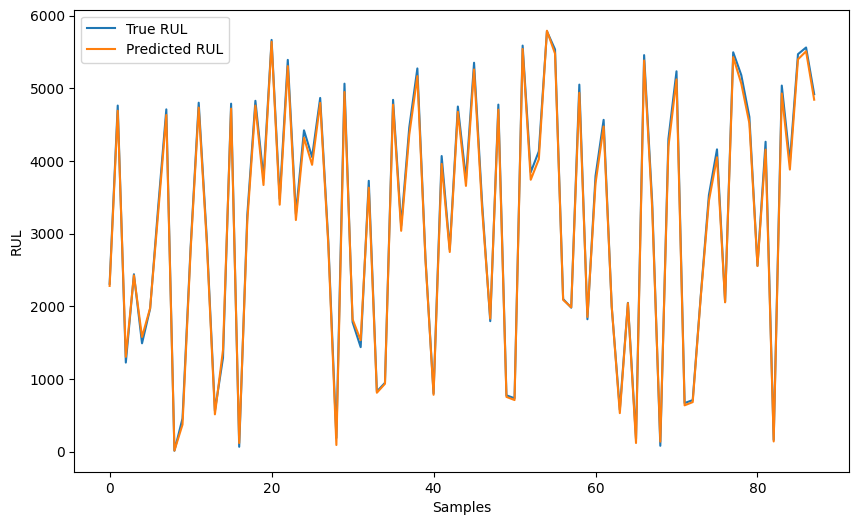

In [15]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Predict RUL on test data
y_pred = model.predict(X_test)

# Rescale the predicted and true values back to the original scale
y_test_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], data.shape[1] - 1)), y_test.reshape(-1, 1))))[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y_pred.shape[0], data.shape[1] - 1)), y_pred)))[:, -1]

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Print the MAPE score
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Plot true vs predicted RUL
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='True RUL')
plt.plot(y_pred_rescaled, label='Predicted RUL')
plt.xlabel('Samples')
plt.ylabel('RUL')
plt.legend()
plt.show()


HyperParamter Tuning to above model

In [8]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

def create_model(trial):
    # Suggest hyperparameters
    lstm_units = trial.suggest_int('lstm_units', 50, 150)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    # Create the model
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(dropout_rate),
        LSTM(lstm_units // 2, return_sequences=False),
        Dropout(dropout_rate),
        Dense(1)
    ])
    
    # Select optimizer
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

def objective(trial):
    model = create_model(trial)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=0)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    y_test_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], data.shape[1] - 1)), y_test.reshape(-1, 1))))[:, -1]
    y_pred_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y_pred.shape[0], data.shape[1] - 1)), y_pred)))[:, -1]
    
    # Calculate MAPE
    mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100
    
    return mape


In [ ]:
# Create a study object
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Print the best parameters
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


C:\Users\pavan\AppData\Local\Temp\ipykernel_22968\3515734553.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
C:\Users\pavan\AppData\Local\Temp\ipykernel_22968\3515734553.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\pavan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
Mean Absolute Percentage Error (MAPE): 15.407357934114433


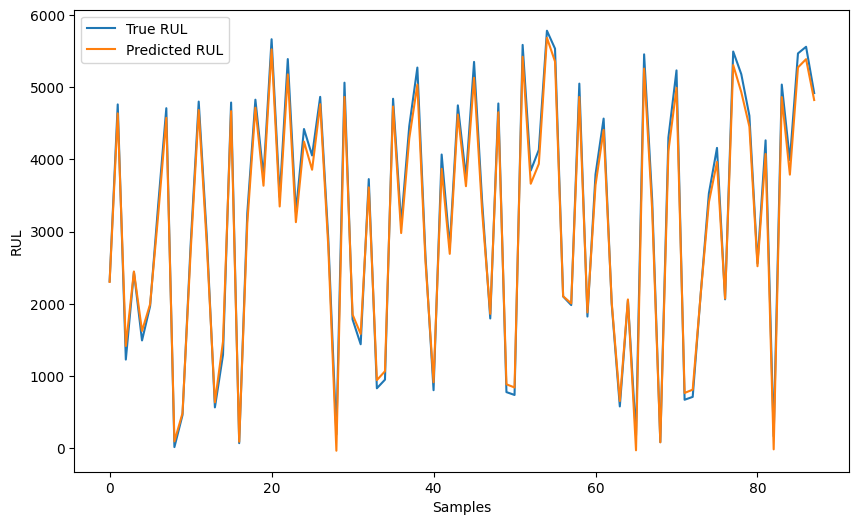

In [14]:
# Create and train the best model
best_model = create_model(trial)
best_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=0)

# Predict RUL on test data
y_pred = best_model.predict(X_test)

# Rescale the predicted and true values back to the original scale
y_test_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], data.shape[1] - 1)), y_test.reshape(-1, 1))))[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y_pred.shape[0], data.shape[1] - 1)), y_pred)))[:, -1]

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)

# Print the MAPE score
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Plot true vs predicted RUL
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='True RUL')
plt.plot(y_pred_rescaled, label='Predicted RUL')
plt.xlabel('Samples')
plt.ylabel('RUL')
plt.legend()
plt.show()
